# Background

In our data story/visualization notebook, we inspected the data for possible bias and trends. The data appeared reasonable. However, we now turn our focus to how we can use the data to categorize music critics in a meaningful way for inputting to a recommendation engine.


In [68]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy import stats
import seaborn as sns
import pickle

%matplotlib inline
sns.set()

In [69]:
df_pitchfork_spotify = pd.read_pickle('df_pitchfork_spotify.pkl')
df_pitchfork = pd.read_pickle('df_pitchfork.pkl')
df_authors_reviews = pd.read_pickle('df_authors_reviews.pkl')
df_features = pd.read_pickle('df_features.pkl')

# 1. Do audio features impact album rating?

----------------------

In the data visualization notebook, we plotted a large pairplot to visualize any obvious correlations between audio features, and audio features vs. score (album rating). Visualizing any trend between features & score were difficult, so we refine our analysis here.

In [70]:
df_features.head()

,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,score,popularity,reviewid
0,0.1027681818,0.6041818182,347475.1818181818,0.5367272727,0.6088181818,6.0000000000,0.1160272727,-11.0094545455,0.3636363636,0.0445545455,126.1810000000,4.0000000000,0.3600090909,9.3,61,22703
1,0.0000140200,0.1310000000,522000.0000000000,0.8670000000,0.7027500000,5.5000000000,0.3710000000,-10.0625000000,1.0000000000,0.0791000000,125.4172500000,3.7500000000,0.0974500000,7.9,8,22721
2,0.2398737250,0.4450000000,175396.3750000000,0.6752500000,0.2532515925,5.2500000000,0.1715750000,-7.4176250000,0.5000000000,0.2067625000,108.2242500000,3.8750000000,0.4981250000,7.3,25,22659
3,0.0177010429,0.5502857143,236645.7142857143,0.5588571429,0.6891142857,5.4285714286,0.3978571429,-11.0792857143,0.5714285714,0.1280571429,128.8520000000,4.1428571429,0.3672000000,8.1,11,22725
4,0.3421947826,0.6562608696,173682.9130434783,0.6576086957,0.0176078839,4.7826086957,0.2810782609,-6.1623913043,0.6086956522,0.2559086957,110.5818695652,3.7391304348,0.5176956522,7.4,56,22722


## 1.1 Inspect correlations between audio features

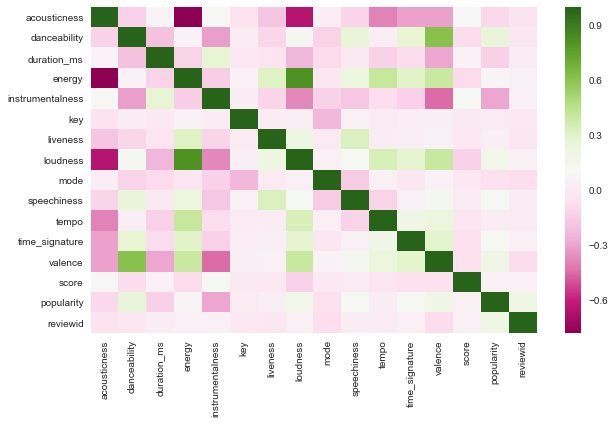

In [71]:
fig, ax = plt.subplots(figsize=(10,6))
sns.heatmap(df_features.corr(), ax=ax, cmap="PiYG");

As expected, there are a few strong correlations between some audio features. However, audio features vs. score still ambiguous. Instrumentalness may be significant. 

We proceed with training a model to pick out features that may particularly impact an album's score.

## 1.2 Train a model: audio features to predict score

Getting overall impression of which audio features might impact score, irrespective of the individual critic who rated the album.

#### Replace NaN's w/ mean

Our strategy for dealing with the occasional NaN value is to replace it with that column's mean.

In [72]:
df_features = df_features.fillna(df_features.mean())

#### Train a linear regression model

Where predictors are album audio features and prediction is album rating.

In [73]:
# list of all album features: audio track features & popularity, to feed to model
X = df_features[['acousticness', 'danceability', 'duration_ms', 'energy', 'instrumentalness', 'key', 
                 'liveness', 'loudness', 'mode', 'speechiness', 'tempo', 'time_signature', 'valence', 
                 'popularity']]

# what we want to predict: album rating
y = df_features['score'].values.reshape((len(df_features),1))

In [74]:
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LinearRegression

# split data into train & test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=101)

# linear fit to training set
lm = LinearRegression() # create linear model object
lm.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [75]:
# suppress scientific notation
pd.set_option('display.precision',10)

# results: coefficients for each feature
cdf = pd.DataFrame(lm.coef_[0], X.columns, columns=['Coeff'])
cdf

,Coeff
acousticness,0.1990463482
danceability,-1.2102899337
duration_ms,0.0000002547
energy,-0.2270055940
instrumentalness,0.5866557989
key,0.0101375556
liveness,0.0013788012
loudness,-0.0268456344
mode,0.1134753422
speechiness,1.1305637304


Many of the coefficients are actually pretty impactful, if we envison at least a 0.1 change in a review's rating to be significant to a critic/reader's perception of the album. Next step now is to check model validity.

#### Check model against test set

In [76]:
# generate predictions for test set, based on the model we just generated above
predictions = lm.predict(X_test)

Mean absolute error:  0.9215430378044821
Mean squared error:  1.546569823644831
RMSE:  1.243611604820746


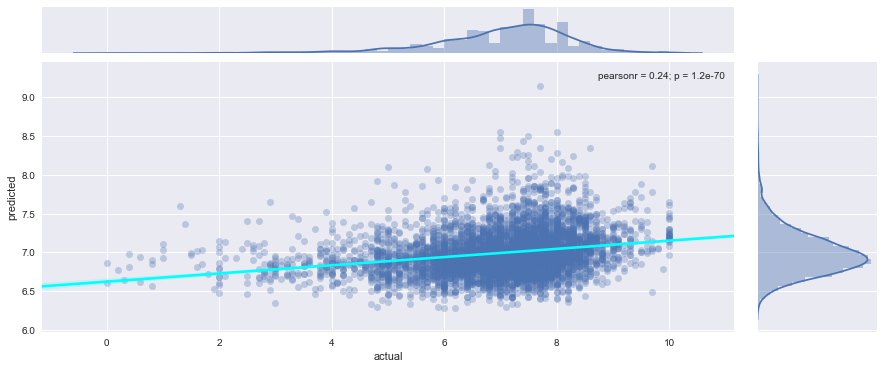

In [77]:
g = sns.jointplot(y_test, predictions, kind='reg', joint_kws={'line_kws':{'color':'cyan'}, 'scatter_kws': {'alpha': 0.3}});
g.fig.set_size_inches(13,5);
plt.xlabel('actual');
plt.ylabel('predicted');

from sklearn import metrics

print('Mean absolute error: ', metrics.mean_absolute_error(y_test, predictions))
print('Mean squared error: ', metrics.mean_squared_error(y_test, predictions))
print('RMSE: ', np.sqrt(metrics.mean_squared_error(y_test, predictions)))

Relationship between predicted and actual values is significant (pval < 0.01) at R = 0.24.

#### Plot histogram of residuals

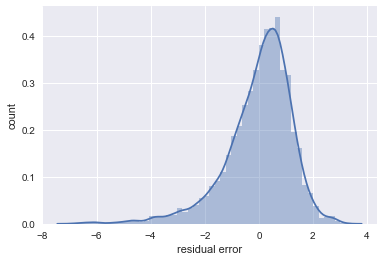

In [78]:
sns.distplot((y_test-predictions));
plt.xlabel('residual error');
plt.ylabel('count');

Residuals (actual minus predicted) has fairly normal-looking distribution, which is a good sign.

## 1.3 Discussion

Now that we've demonstrated that the model produces significant audio feature predictors for album rating, how do we proceed?

Recall that our ultimate goal is to determine some method of clustering music critics, whether it is along the music they tend to rate or audio features they prefer, both weighed by the rating they assign the corresponding albums. The next step is to assign a model for each critic that includes some combination, or all, of these parameters. The model aims to predict what the critic would have rated the album, based on these weighed parameters.

Determining this combination of parameters for a critic model is complicated and will yield different residual errors. However, our results in this section 1 help guide a starting point - ex. perhaps begin by just including audio features w/ coeff >= |0.1|.

# 2. Test whether linear regression is suitable for music critic model
----------------------
Now we begin to test different types of modelling to see which is most suitable for our recommendation system.

In [79]:
# Adding Pitchfork reviewid to features dataframe for analysis
df_features['reviewid'] = df_pitchfork_spotify['reviewid']
df_features.head()

,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,score,popularity,reviewid
0,0.1027681818,0.6041818182,347475.1818181818,0.5367272727,0.6088181818,6.0000000000,0.1160272727,-11.0094545455,0.3636363636,0.0445545455,126.1810000000,4.0000000000,0.3600090909,9.3,61,22703
1,0.0000140200,0.1310000000,522000.0000000000,0.8670000000,0.7027500000,5.5000000000,0.3710000000,-10.0625000000,1.0000000000,0.0791000000,125.4172500000,3.7500000000,0.0974500000,7.9,8,22721
2,0.2398737250,0.4450000000,175396.3750000000,0.6752500000,0.2532515925,5.2500000000,0.1715750000,-7.4176250000,0.5000000000,0.2067625000,108.2242500000,3.8750000000,0.4981250000,7.3,25,22659
3,0.0177010429,0.5502857143,236645.7142857143,0.5588571429,0.6891142857,5.4285714286,0.3978571429,-11.0792857143,0.5714285714,0.1280571429,128.8520000000,4.1428571429,0.3672000000,8.1,11,22725
4,0.3421947826,0.6562608696,173682.9130434783,0.6576086957,0.0176078839,4.7826086957,0.2810782609,-6.1623913043,0.6086956522,0.2559086957,110.5818695652,3.7391304348,0.5176956522,7.4,56,22722


In [80]:
df_features.to_pickle('df_features.pkl')

#### Normalize features

So that features w/ relatively much lower/higher scales don't distort the regression.

In [81]:
from sklearn import preprocessing

df = df_features[['acousticness', 'danceability', 'duration_ms', 'energy', 'instrumentalness', 'key', 
                  'liveness', 'loudness', 'mode', 'speechiness', 'tempo', 'time_signature', 'valence', 
                  'popularity']]

x = df.values
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df2 = pd.DataFrame(x_scaled, columns=df.columns)

df_features[['acousticness', 'danceability', 'duration_ms', 'energy', 'instrumentalness', 'key', 
             'liveness', 'loudness', 'mode', 'speechiness', 'tempo', 'time_signature', 'valence', 
             'popularity']] = df2

## 2.1 Case study: start by testing 1 reviewer

We want to determine whether it is possible to assign an accurate individual model to each critic, where the parameters are album features and predicted outcome is the rating they assigned to the album.

#### To start, we sample the first critic that appears in our authors/reviews database and attempt to model their rating. 

This critic, Aaron Leitko, happens to have 83 reviews - on the higher side of # reviews for a nice sample size.

In [82]:
# first row author's data ('aaron leitko'):

row = df_authors_reviews.loc[0]
author = row['author_fullname']
reviews = row['reviews']
r = 21950
row

author_fullname                                           aaron leitko
reviews              [21950, 21820, 21753, 21622, 21572, 21283, 213...
num_reviews                                                         97
years_experience                                                     9
ratings_mean                                               7.197938144
weighted_features    {21950: {'acousticness': 0.7706920094758397, '...
Name: 0, dtype: object

#### Train linear regression model on the critic

In [83]:
# make unique dataframe for critic, where each row = an album's features & the critic's rating

df = df_features[df_features.reviewid.isin(reviews)] # compile all rows of author's reviews

# list of all album features: audio track features & popularity, to feed to model
X = df[['acousticness', 'danceability', 'duration_ms', 'energy', 'instrumentalness', 'key', 'liveness', 
        'loudness', 'mode', 'speechiness', 'tempo', 'time_signature', 'valence', 'popularity']]

# what we want to predict: critic's album rating
y = df['score'].values.reshape((len(df),1))

# split data into train & test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=101)

# linear fit to training set
lm = LinearRegression() # create linear model object
lm.fit(X_train, y_train)

# produce correlation coefficients
pd.set_option('display.precision',10)
cdf = pd.DataFrame(lm.coef_[0], X.columns, columns=['Coeff'])

#### Evaluate model performance

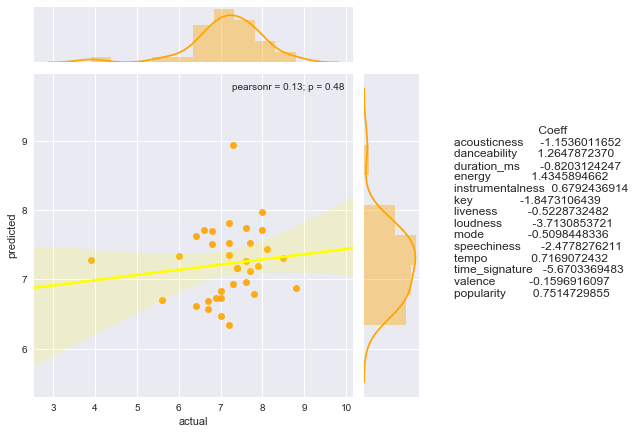

In [84]:
# generate predictions for test set, based on the model we just generated above
predictions = lm.predict(X_test)

g = sns.jointplot(y_test, predictions, kind='reg', joint_kws={'line_kws':{'color':'yellow'}, 'scatter_kws': {'alpha': 0.9}}, color='orange');
plt.xlabel('actual');
plt.ylabel('predicted');
plt.figtext(1.05, 0.3, cdf);

<i><b>Results:</b></i>
- <b>Individual critic models are insufficient.</b> The model doesn't predict the critic's ratings very well, and neither do the actual vs. predicted ratings correlate very well (i.e. model isn't a statistically significant at predicting rating) - further indication of poor fit.
<p>
- <b>Neither do other models.</b> Additionally, doesn't look like a logistic regression or some other type of fit would work either.
<p>
- <b>Removing weak coeff doesn't work either.</b> Since this model incorporated all features irrespective of the strength of their coeff, we proceeded by removing the smaller corrcoef parameters to see if this improves the model (not shown here). However, the model still did a poor job of predicting actual ratings and lacking in statistical significance. 

## 2.2 Discussion

We saw that implementing linear regression on an individual-critic basis was not sufficient to predict ratings.

- <b>Insufficient sample size of reviews for each critic.</b> There probably needs to be a higher sample size for this critic to achieve statistical significance, if some relationship between album features and ratings can be drawn. However, this reviewer actually has 83 ratings, which is on the higher end compared to many other critics. Therefore, we probably can't expect statistical significance when performing linear regression modelling (on an indivdiual-critic basis) on the majority of critics.
<p>
- <b>Proceed with cluster analysis.</b> We should probably do a cluster analysis first - this might allow us to group critics together to increase review sample size.

# 3. Clustering critics - K Means Clustering
----------------------
Approach:
1. Compile dataframe, where each row represents a critic and each column is the album feature's average, weighed by the rating the critic assigned the album.
2. Cluster critics by weighed features.

In [85]:
from sklearn.cluster import KMeans
from sklearn import preprocessing

## 3.1 Data wrangling to set up Kmeans clustering

#### Define function that will weigh the features for each album an author has rated. 

In [86]:
def weight_features(df, author_fullname): # df argument must be a dataframe where each row = album

    reviewid = df['reviewid']
    score = df['score']
    
    # drop score, popularity, and reviewid to avoid confounding kmeans clustering
    df = df.drop('score', axis=1)
    df = df.drop('popularity', axis=1)
    df = df.drop('reviewid', axis=1)
    
    # multiply each feature by the critic's rating
    df_weighted = df.multiply(score.values, axis=0)
    df_weighted.index = reviewid

    # store dataframe in dict
    dict_weighted = df_weighted.to_dict(orient='index')

    # average weighted features
    dict_weighted_mean = {author: pd.DataFrame(df_weighted.mean()).transpose()}
    
    return dict_weighted, dict_weighted_mean

#### Generate dataframe ('df_kmeans') that compiles the average of critics' album features, weighed by their rating to it.

In [87]:
df_kmeans = pd.DataFrame()
list_df_weighted = []

for index, row in df_authors_reviews.iterrows():

    reviews = row['reviews']
    author = row['author_fullname']
    
    # compile dataframe of album features of all the author's reviews
    df_author = None
    for r_id in reviews:
        if df_author is None: # initialize dataframe
            df_author = df_features[df_features['reviewid']==r_id]
        else:
            df_author = df_author.append(pd.DataFrame(df_features[df_features['reviewid']==r_id]))
    
    if df_author.empty:
        df_kmeans = pd.concat([df_kmeans, pd.DataFrame(np.full((1,len(df_kmeans.columns)), np.nan), columns=df_kmeans.columns)])
        list_df_weighted.append(np.nan)
        continue # continue if author's reviews have no features (i.e. Spotify didn't have data for it)
                               
    # weigh features
    dict_weighted, dict_weighted_mean = weight_features(df_author, author)

    # replace placeholder w/ normed features dataframe (converted to dict for storage)
    if df_kmeans.empty: # initialize dataframe 
        df_kmeans = dict_weighted_mean[author]
    else:
        df_kmeans = pd.concat([df_kmeans, dict_weighted_mean[author]])
    
    # save weighted features to append to authors/reviews dataframe for later use
    list_df_weighted.append(dict_weighted)

        
df_kmeans = df_kmeans.set_index(df_authors_reviews['author_fullname']) # index new features dataframe by author
df_kmeans.head()

,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
author_fullname,,,,,,,,,,,,,
aaron leitko,1.7663100768,2.7239289792,0.4380054298,4.8143947997,3.6469420755,3.4594752437,1.3227202015,5.6306407768,5.1378713133,0.3225992420,3.4506944130,5.0852732049,2.8349617526
abigail covington,1.4951118364,4.5360173469,0.3154418588,4.3567193344,0.0626842169,3.6649783550,1.3568244620,5.7701599203,3.6304761905,1.4365050169,2.8159083971,5.0975000000,3.6847003832
abigail garnett,1.1339904909,5.0404854225,0.4836792834,4.8605728242,4.7636920511,3.5671690935,0.7229501287,5.4236979620,4.2677669553,0.2872338269,3.3146946336,5.1918551587,3.7490541335
adam dlugacz,0.0012127985,2.0102734596,0.2351180050,5.2985298573,0.4313224214,2.4230769231,2.0638801090,5.4037899891,4.8461538462,0.1949768670,3.6321965228,4.7250000000,2.5469475417
adam moerder,1.2528502263,2.8514575058,0.2769794397,4.2210098867,1.5580908162,2.9556970657,0.9947820804,4.9632705169,4.1546743725,0.2922627678,3.0369497445,4.3824467362,2.8337192757


In [88]:
# append weighted features to author entry in authors/reviews dataset
df_authors_reviews['weighted_features'] = list_df_weighted
df_authors_reviews.head()

,author_fullname,reviews,num_reviews,years_experience,ratings_mean,weighted_features
0,aaron leitko,"[21950, 21820, 21753, 21622, 21572, 21283, 213...",97,9,7.1979381443,"{21950: {'acousticness': 0.7706920094758397, '..."
1,abigail covington,"[22138, 21544]",2,0,7.0500000000,"{22138: {'acousticness': 0.5443133695435528, '..."
2,abigail garnett,"[21050, 20968, 20694, 20570, 20405, 20134, 199...",9,1,7.0888888889,"{21050: {'acousticness': 2.1077528288718304, '..."
3,adam dlugacz,[6794],1,0,6.3000000000,"{6794: {'acousticness': 0.001212798478865301, ..."
4,adam moerder,"[13207, 13007, 12956, 12939, 12861, 12673, 126...",209,4,6.1516746411,"{13207: {'acousticness': 0.3490780776030364, '..."


##### Pickle dataframes

In [89]:
# Updating Pickled 'df_authors_reviews' w/ new data
df_authors_reviews.to_pickle('df_authors_reviews.pkl')

# Saving new pickle: more convenient lookup table of critics' weighted scores
df_kmeans.to_pickle('df_kmeans.pkl')

## 3.2 Exploratory data analysis (EDA) to determine cluster size

In order to determine cluster size and adjust other parameters in our kmeans clustering, we do some exploratory data analysis and wrangling first. Here, we take a score-weighted approach: score-weighted features refers to multiplying normalized features by their album's score.

#### Perform elbow method of determining a good # of clusters

The elbow method involves plotting SSE (sum squared errors) for progressively larger number of clusters (k) specified to the algorithm and then picking a k where SSE decreases abruptly. The idea is that SSE decreases as k gets larger, and at some point the marginal return of higher k is not worth increasing k further.

<i>Analyze a ton of cluster sizes:</i>

In [90]:
inertia1 = []
for i in range(1,100):
    n_clusters = i
    df = df_kmeans[np.isfinite(df_kmeans['acousticness'])]
    kmeans = KMeans(n_clusters).fit(df)
    inertia1.append(kmeans.inertia_)

<i>Then proceed w/ zooming into a promising range of sizes:</i>

In [91]:
inertia2 = []
for i in range(1,18):
    n_clusters = i
    df = df_kmeans[np.isfinite(df_kmeans['acousticness'])]
    kmeans = KMeans(n_clusters).fit(df)
    inertia2.append(kmeans.inertia_)

<i>Plot to visualize the "elbow"</i>

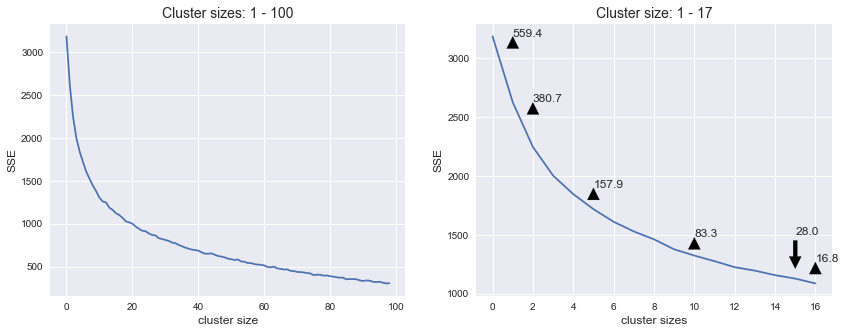

In [95]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(14,5))

# fig 1: plotting SSE's for cluster sizes 1-100
ax1.plot(inertia1);
ax1.set_xlabel('cluster size', fontsize=12)
ax1.set_ylabel('SSE', fontsize=12)
ax1.set_title('Cluster sizes: 1 - 100', fontsize=14)

# fig 1: zooming in to SSE's vs. cluster sizes 1-17
ax2.plot(inertia2);
ax2.set_xlabel('cluster sizes', fontsize=12)
ax2.set_ylabel('SSE', fontsize=12)
ax2.set_title('Cluster size: 1 - 17', fontsize=14)

# annotating fig 2 w/ slope sizes
ax2.annotate('559.4', xy=(1,3185.9), xytext=(1, 3185.9), arrowprops=dict(facecolor='black', shrink=0.05));
ax2.annotate('380.7', xy=(2,2626), xytext=(2, 2626), arrowprops=dict(facecolor='black', shrink=0.05));
ax2.annotate('157.9', xy=(5,1900), xytext=(5, 1900), arrowprops=dict(facecolor='black', shrink=0.05));
ax2.annotate('83.3', xy=(10,1480), xytext=(10, 1480), arrowprops=dict(facecolor='black', shrink=0.05));
ax2.annotate('28.0', xy=(15,1200), xytext=(15, 1500), arrowprops=dict(facecolor='black', shrink=0.05));
ax2.annotate('16.8', xy=(16,1270), xytext=(16, 1270), arrowprops=dict(facecolor='black', shrink=0.05));

It seems that > 15 clusters is not worth the tradeoff of too many clusters (which will reduce train/test dataset sizes for testing cluster accuracy), based on plateauing SSE. Particularly since > 15 clusters will tend to cause an error in the clustering algorithm, where some clusters are empty (EDA not shown here).

So we set our upper cluster size limit to 15 and proceed w/ examining correlations & p-values for each cluster size in the next section.

## 3.3 EDA to determine cluster quality

Elbow method will visualize SSE, but no matter how good any stats are, if our actual vs. predicted ratings isn't accurate, our model won't be useful for generating a recommendation engine. 

So we proceed by examining p-value, Pearson's R, and slope of linear regression to see how the clusters under k cluster size-specifications perform.

#### <i> Optional: load a specific kmeans run
    
Loading saved output from a kmeans run, which is referenced in the examples following kmeans clustering below. If loading this kmeans run, skip next step of implementing kmeans clustering, which will generate a different dataset from the one that will be referred to in discussions below.

In [96]:
# Loading a specific kmeans run, where random state = 94
with open('objs.pkl','rb') as f:  # Python 3: open(..., 'rb')
    df_kmeans2, cdf, y_test, prediction, slope, r_value, p_value, size, author = pickle.load(f)

#### Define some functions

In [97]:
# function: return reviewids of all critics belonging to the cluster

def cluster_reviews(cluster_num):
    
    df = df_kmeans2[df_kmeans2['cluster']==cluster_num]
    authors = df.index
    
    reviewids = []
    for a in authors:
        reviews = df_authors_reviews[df_authors_reviews['author_fullname']==a]['reviews']
        reviews = list(reviews)[0]
        reviewids.extend(reviews)
        
    return reviewids

In [98]:
# function: take all reviews belonging to cluster, generate linear model prediction for rating, plot predicted vs. actual rating

def cluster_examine(cluster_num, features): # features must be a list
    
    # extract reviews belonging to cluster
    reviewids = cluster_reviews(cluster_num) # list of all reviews belonging to cluster
    df = df_features[df_features['reviewid'].isin(reviewids)] # features of all these reviews
    size = len(df)
    
    # extract authors belonging to cluster
    df2 = df_pitchfork[df_pitchfork['reviewid'].isin(reviewids)]
    author = df2['author'].unique()
    
    # set features we want in model
    X = df[features]
    
    # train model
    y = df['score'].values.reshape((len(df),1))
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)
    lm = LinearRegression() # create linear model object
    lm.fit(X_train, y_train) # fit linear regression model to data
    pd.set_option('display.precision',10)
    cdf = pd.DataFrame(lm.coef_[0], X.columns, columns=['Coeff']) # table of parameter coefficients

    # generate predictions for test set, based on the model we just generated above
    prediction = lm.predict(X_test)
    
    # scipy linregress
    slope, intercept, r_value, p_value, std_err = stats.linregress(y_test[:,0], prediction[:,0])
    
    return cdf, X_train, X_test, y_train, y_test, prediction, slope, r_value, p_value, size, author

#### Perform kmeans clustering

From manually implementing different cluster sizes (k), it seems k > 13 are much more likely to yield error w/ cluster size 0's. So we use k=12 here.

In [99]:
# Remove NaN's from data
df_kmeans2 = df_kmeans[np.isfinite(df_kmeans['acousticness'])]

# do kmeans clustering
n_clusters = 12 # specify number of clusters
kmeans = KMeans(n_clusters, random_state=94).fit(df_kmeans2)
labels = kmeans.labels_
inertia = kmeans.inertia_

# append cluster info to data
# df_kmeans2['cluster'] = 1 # placeholder
df_kmeans2['cluster'] = labels # replace w/ cluster label

c:\users\diana\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


#### Compile info on each cluster

In [102]:
cdfs=[]; y_tests=[]; predictions=[]; slopes=[]; r_values=[]; p_values=[]; sizes=[]; authors=[]; size_authors=[]
n_clusters = 12

for cluster_num in range(n_clusters): # recall 'n_clusters' = max # of clusters we specified to kmeans algorithm
    
    # set desired features (default = all)
    features = ['acousticness', 'danceability', 'duration_ms', 'energy', 'instrumentalness', 
                'key', 'liveness', 'loudness', 'mode', 'speechiness', 'tempo', 'time_signature', 
                'valence', 'popularity']
    
    # fit linear model
    cdf, X_train, X_test, y_train, y_test, prediction, slope, r_value, p_value, size, author = cluster_examine(cluster_num, features)
    
    # store results
    cdfs.append(cdf)
    y_tests.append(y_test)
    predictions.append(prediction)
    slopes.append(slope)
    r_values.append(r_value)
    p_values.append(p_value)
    sizes.append(size)
    authors.append(author)
    size_authors.append(len(author))

# produce table of a few selected stats (pval, r, cluster size, slope)
pd.DataFrame({'slopes':slopes, 'r_values': r_values, 'p_values':p_values, 'size_reviews':sizes, 'size_authors':size_authors})

,p_values,r_values,size_authors,size_reviews,slopes
0,9.9186979577e-01,-0.0033037501,11,40,-0.0065873954
1,1.0961503288e-08,0.2203074409,35,2195,0.0677401385
2,1.2286249603e-16,0.2351344512,90,4024,0.0520472717
3,4.6494382414e-05,0.5526072579,18,158,0.2417603133
4,8.3266383494e-11,0.2121965041,62,3060,0.0434454902
5,3.7625967813e-03,0.1542756227,58,1169,0.0276925561
6,6.2213013177e-01,0.1587631865,13,37,0.1508761660
7,1.3779421166e-06,0.2863349274,32,914,0.0697689959
8,0.0000000000e+00,-1.0000000000,4,4,-1.5457497853
9,7.8876904215e-02,-0.9923342646,7,10,-0.9382789959


Each row represents a stats from a cluster's linear regression model, indexed by its cluster number. 

<b>Results:</b> 
- <b>A strong cluster.</b> Cluster 9 (if the optional, specific kmeans run is loaded) looks particularly strong, with a R = -0.99 and 7 critics/10 reviews.
<p>
- <b>Strong, but small clusters.</b> Regardless, from several kmeans runs (EDA not shown), there are usually several clusters that have strong agreement (R ~= 1) between actual vs. predicted rating BUT have very small sizes of critics and reviews. 
<p>
- <b>High between-cluster variability.</b> Furthermore, it's clear that there is a large amount of variability between clusters - specfically how well the cluster's linear regression model was able to predict its critics' ratings. Often, 1 or 2 clusters will perform extremely well, and then the rest be all over the place within 0.0 < R < 0.5
<p>

<b>How to proceed?</b> One idea is to grab the best-performing cluster from each kmeans run and repeat runs, until all critics are clustered. In the following section, we explore this idea further.

## 3.4 Examine specific, well-performing clusters

There is a high degree of variability between cluster performance, but occasionally kmeans runs will yield a cluster whose R and size stand out as particularly "good". Here, we examine such a cluster (Cluster 9) from our loaded example.

#### Make function to plot specific cluster's performance (on linear regression).

If we want to examine well-performing clusters more closely.

In [ ]:
def cluster_plot(cluster_num, features): # features must be a list
    
    # grab info from previous section (i.e. where we linreg modelled all clusters)
    y_test = y_tests[cluster_num]
    prediction = predictions[cluster_num]
    
    # plot
    g = sns.jointplot(y_test[:,0], prediction[:,0], kind='reg', color='orange',
                      joint_kws={'line_kws':{'color':'yellow'}, 'scatter_kws': {'alpha': 0.9}});
    plt.xlabel('actual');
    plt.ylabel('predicted');

#### Examine Cluster 9 from the kmeans results loaded earlier.

In [ ]:
cluster_num = 9
features = ['acousticness', 'danceability', 'duration_ms', 'energy', 'instrumentalness', 'key', 
            'liveness', 'loudness', 'mode', 'speechiness', 'tempo', 'time_signature', 'valence', 
            'popularity']
cluster_plot(cluster_num, features)

There are fewer data points (3) than cluster size (10), because to get a measure of model accuracy, we must rely on the test set and its predicted values. Our test set size was set to 0.3 of total dataset size. 

Not pictured here are other iterations of "well-performing" clusters. What they all have in common is a fairly good fit and an acceptable number of data points. However, we need to get specific about how to choose select a "well-performing" cluster to set aside.

## 3.5 Discussion: criteria for "best-performing" cluster

Plotting Cluster 9 in the previous section allowed us to visualize the high agreement between actual and predicted ratings, based on linear regression on the reviews written by critics in that cluster. There are 7 critics with 10 reviews in total. 

Evaluating what is a "best-performing" cluster from each iteration of kmeans is subjective, but let's try to define some criteria:
- <b> Size >= 5.</b> There needs to be more than 5 reviews in the cluster, otherwise the cluster size is impractically small and our recommendation engine may rely on too many overfitted models.
<p>
- <b> Critics >= 2.</b> Same reason as above. Additionally:
    - Since the clusters that our recommedation engine relies on will be based on similarity between critics, only at least 2 critics are required to create a cluster.
    - Unlike reviews (13585 total), there are only 366 unique critics after all our data wrangling. So having a cluster size of 2 critics won't be as drastically overfitted as a cluster size of 2 reviews, for example.
    
<p>
- <b> R >= 0.9.</b> This requires us to consider the subjective territory of how many points difference a rating would make on a consumer's perception of the album. 
    - Recall the Pitchfork rating system is 0-10. Would a scale of 0.1 or 1 points make a difference? R = 0.9 would mean that the rating could be off around 1.0 points, which might make a difference between considering listening to an 9.0-rated album vs. 10.0-rated album, or 7.0 vs. 8.0.
    - However, this consideration must also be balanced with practical consideration for our modelling constraints. From several kmeans runs, it seems an R > 0.9 with review size > 5 is rare, but possible. Since we can afford to automate kmeans runs until this criteria is hit, we set 0.9 as our R criteria for now.

# 4. Conclusion
---------------------------

Now that we have set up an environment to generate clusters and pick the “best-performing” ones, we must determine how to proceed with our results. As seen with multiple runs (EDA not shown here), there is usually large inconsistency between clusters’ performances with each kmeans run.

Because of this inconsistency, our next step is to write an algorithm that grabs the best-performing cluster out of k clusters and repeats the process, until all critics are clustered:
1. Run kmeans on dataset and identify best-performing cluster.
2. Save cluster and the critics belong to this cluster, then remove critics from dataset.
3. Run kmeans again on the reduced dataset.

We will repeat this process until all the critics are assigned to well-performing clusters.